In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
plt.rcParams['figure.figsize'] = (10,8)
import pickle as pkl
from mre import pytorch_unet
from tensorboardX import SummaryWriter

# Load mre data
full_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/'
ds = pkl.load(open(full_data_dir+'mre_ds_preprocess_3.p', 'rb'))

In [2]:
ds

<xarray.Dataset>
Dimensions:      (sequence: 10, subject: 50, x: 256, y: 256, z: 4)
Coordinates:
  * subject      (subject) <U3 '148' '162' '163' '178' ... '404' '405' '406'
  * sequence     (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
Dimensions without coordinates: x, y, z
Data variables:
    image        (subject, sequence, z, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    age          (subject) int8 -59 -27 -91 -107 117 ... -107 -107 5 -59 101
    z_space      (subject, sequence) float16 13.8 10.0 10.0 10.0 ... 0.0 0.0 0.0
    z_space_std  (subject) float16 1.684 1.684 3.826 1.2 ... 3.812 1.049 2.854

In [3]:
print(ds.sequence)
print(ds.subject[0])

<xarray.DataArray 'sequence' (sequence: 10)>
array(['T1Pre', 'T1Pos', 'T2FR', 'T2SS', 'elastMsk', 'elast', 'msk',
       'liverMsk', 'extra2', 'extra3'], dtype='<U8')
Coordinates:
  * sequence  (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
<xarray.DataArray 'subject' ()>
array('148', dtype='<U3')
Coordinates:
    subject  <U3 '148'


In [4]:
# Use xArray to define the dataset.  Easy to query and map (although might not be fast when scaling up)
input_example = ds.sel(sequence=['T2SS', 'T1Pre', 'T1Pos', 'T2FR']).image
target_example = ds.sel(sequence=['elast']).image

In [5]:
input_example.values.shape

(50, 4, 4, 256, 256)

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

# need data to be ordered thusly:
# image_sequence,width,hight,depth
class MREDataset(Dataset):
    def __init__(self, xa_ds, set_type='train', transform=None, clip=False):
        inputs = ['T1Pre', 'T1Pos', 'T2SS', 'T2FR']
        targets = ['elast']
        masks = ['liverMsk']
        
        # stack subject and z-slices to make 4 2D image groups for each 3D image group
        xa_ds = xa_ds.stack(subject_2d = ('subject', 'z')).reset_index('subject_2d')
        subj_2d_coords = [f'{i.subject.values}_{i.z.values}' for i in xa_ds.subject_2d]
        xa_ds.assign_coords(subject_2d=subj_2d_coords)
        self.name_dict = dict(zip(range(len(subj_2d_coords)), subj_2d_coords))
        
        if set_type == 'train':
            input_set = xa_ds.subject_2d[:-20]
        elif set_type == 'val':
            input_set = xa_ds.subject_2d[-20:]
        else:
            raise AttributeError('Must choose one of ["train", "val"] for `set_type`.')
            
        
        self.input_images = xa_ds.sel(sequence=inputs, subject_2d=input_set).transpose(
            'subject_2d', 'sequence', 'y', 'x').image.values
        #ds.sel(sequence=inputs, subject=subjects).stack(subject_2d=('subject','z')).transpose('subject_2d','sequence', 'y', 'x').image.values.shape
        self.target_images = xa_ds.sel(sequence=targets, subject_2d=input_set).transpose(
            'subject_2d', 'sequence', 'y', 'x').image.values
        self.mask_images = xa_ds.sel(sequence=masks, subject_2d=input_set).transpose(
            'subject_2d', 'sequence', 'y', 'x').image.values
        self.transform = transform
        self.clip = clip
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        if self.clip:
            image = np.where(image>=750, 750, image)
        target = self.target_images[idx]
        mask = self.mask_images[idx]
        image = torch.Tensor(image)
        target = torch.Tensor(target)
        mask = torch.Tensor(mask)
        if self.transform:
            #image = self.transform(image)
            image = transforms.Normalize([image.mean()], [image.std()])(image)
            #target = self.transform(target)
        
        return [image, target, mask]

# use same transform for train/val for this example
#trans = transforms.Compose([
#   torch.Tensor(),
#])
trans=True
clip=True

train_set = MREDataset(ds, set_type='train', transform = trans, clip=clip)
val_set = MREDataset(ds, set_type='val', transform = trans, clip=clip)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 10

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 180, 'val': 20}

In [40]:
#inputs = ['T1Pre', 'T1Pos', 'T2SS', 'T2FR']
#targets = ['elast']
#subjects = ['365', '368']
#ds_stack = ds.sel(sequence=inputs, subject=subjects).stack(subject_2d=('subject','z'))

In [41]:
#ds_stack = ds_stack.reset_index('subject_2d')
#subj_2d_coords = [f'{i.subject.values}_{i.z.values}' for i in ds_stack.subject_2d]
#ds_stack.assign_coords(subject_2d=subj_2d_coords)

In [42]:
def torch_dl_vis(inputs, targets, masks):
    print('lol')
    titles = ['T1Pre', 'T1Pos', 'T2SS', 'T2FR', 'elast', 'mask']
    n_input = inputs.shape[0]
    n_seq = inputs.shape[1]+targets.shape[1]+masks.shape[1]
    fig, axes = plt.subplots(n_input, n_seq, tight_layout=True, figsize=(2.5*n_seq,2.5*n_input), sharex=True, sharey=True)
    for i in range(n_input):
        for seq in range(n_seq):
            if seq < inputs.shape[1]:
                #set_trace()
                axes[i][seq].imshow(np.asarray(inputs[i,seq,:,:]))
            elif seq < inputs.shape[1]+targets.shape[1]:
                axes[i][seq].imshow(np.asarray(targets[i,seq-inputs.shape[1],:,:]))
            else:
                axes[i][seq].imshow(np.asarray(masks[i,seq-inputs.shape[1]-targets.shape[1],:,:]))
    
            axes[i][seq].axis('off')
            if i == 0:
                axes[i][seq].set_title(titles[seq])
        if seq == 0:
            axes[i][seq].set_xlabel(f'subj = {i}')
    fig.lines.append(plt.vlines(0.8, 0, 1, transform=fig.transFigure))
    plt.show()

torch.Size([10, 4, 256, 256])
torch.Size([10, 1, 256, 256])
lol


/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


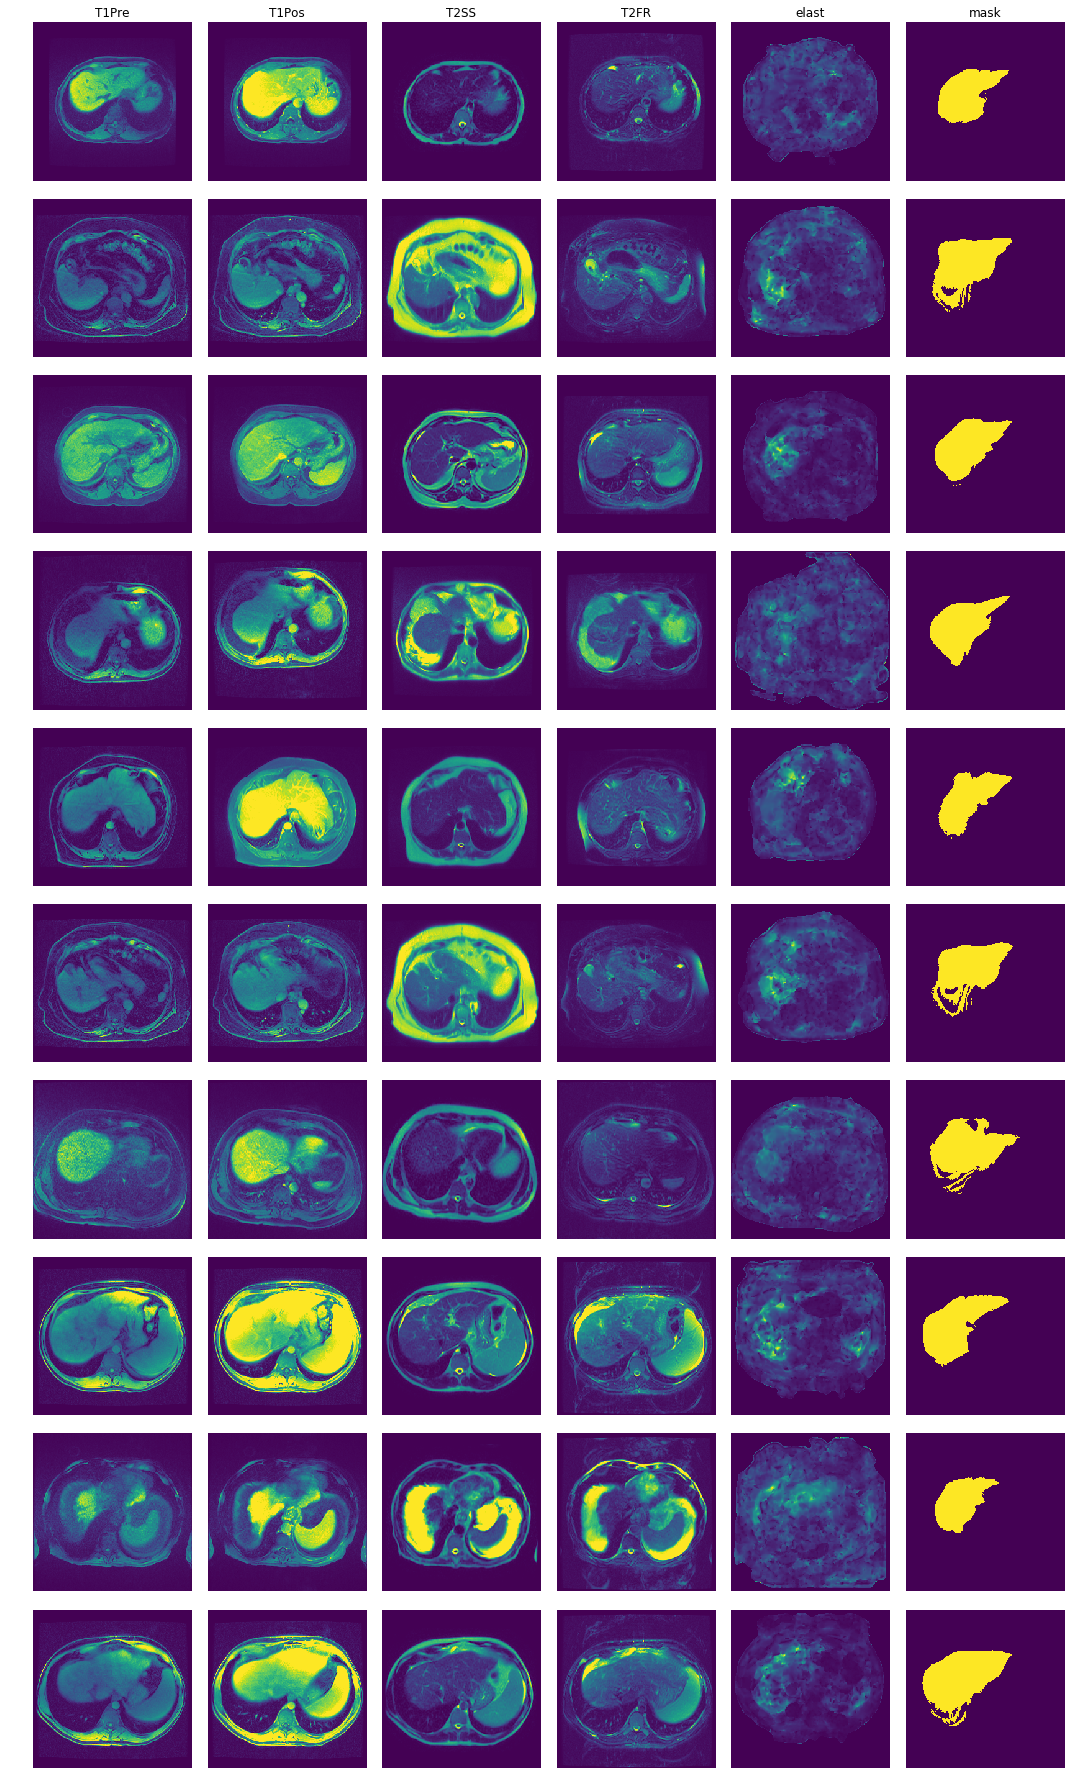

In [43]:
import torchvision.utils

# Get a batch of training data
inputs, targets, masks= next(iter(dataloaders['train']))

#print(inputs.shape, masks.shape)
#for x in [inputs.numpy(), masks.numpy()]:
#    print(x.min(), x.max(), x.mean(), x.std())
print(inputs.shape)
print(targets.shape)

torch_dl_vis(inputs, targets, masks)

In [44]:
from torchsummary import summary
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(1)
model = model.to(device)

summary(model, input_size=(4, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           2,368
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [45]:
from collections import defaultdict
import torch.nn.functional as F
#from loss import dice_loss

#criterion = nn.MSELoss()

def masked_mse(pred, target, mask):
    pred = pred.contiguous()
    target = target.contiguous()
    mask = mask.contiguous()

    masked_mse = (((pred - target)*mask)**2).sum()/mask.sum()
    return masked_mse

def calc_loss(pred, target, mask, metrics, bce_weight=0.5):
    
    #bce = F.binary_cross_entropy_with_logits(pred, target)
        
    #pred = F.sigmoid(pred)
    #dice = dice_loss(pred, target)
    
    #loss = bce * bce_weight + dice * (1 - bce_weight)
    #loss = F.mse_loss(pred, target)
    loss = masked_mse(pred, target, mask)
    
    #metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    #metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25, tb_writer=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e16
    total_iter = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             
                masks = masks.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, masks, metrics)
                    if tb_writer:
                        tb_writer.add_scalar(f'loss_{phase}', loss, total_iter)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                total_iter+=1

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [46]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

#writer = SummaryWriter('runs/baseline')
writer = SummaryWriter('runs/clip_0')
writer = SummaryWriter('runs/clip_norm_0')
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40, tb_writer=writer)
#writer.export_scalars_to_json("./all_scalars.json")
writer.close()




cuda:0
Epoch 0/39
----------
LR 0.0001


/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


train: loss: 15474631.833333
val: loss: 11574404.500000
saving best model
0m 5s
Epoch 1/39
----------
LR 0.0001
train: loss: 11257461.513889
val: loss: 14764235.500000
0m 5s
Epoch 2/39
----------
LR 0.0001
train: loss: 8357140.513889
val: loss: 11422917.000000
saving best model
0m 5s
Epoch 3/39
----------
LR 0.0001
train: loss: 7103682.347222
val: loss: 12615485.000000
0m 5s
Epoch 4/39
----------
LR 0.0001
train: loss: 7268268.277778
val: loss: 12629701.000000
0m 5s
Epoch 5/39
----------
LR 0.0001
train: loss: 7597156.916667
val: loss: 12229864.250000
0m 5s
Epoch 6/39
----------
LR 0.0001
train: loss: 7574897.972222
val: loss: 13290388.000000
0m 5s
Epoch 7/39
----------
LR 0.0001
train: loss: 7362729.847222
val: loss: 13383994.000000
0m 5s
Epoch 8/39
----------
LR 0.0001
train: loss: 7209187.111111
val: loss: 13078917.500000
0m 5s
Epoch 9/39
----------
LR 0.0001
train: loss: 6948341.291667
val: loss: 13377019.000000
0m 5s
Epoch 10/39
----------
LR 0.0001
train: loss: 6780058.430556
val

In [14]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_loader =  DataLoader(val_set, batch_size=1, shuffle=True, num_workers=0)
#test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels, masks = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
labels = labels.data.cpu().numpy()
inputs = inputs.data.cpu().numpy()
masks = masks.data.cpu().numpy()
print(inputs.shape)

# Change channel-order and make 3 channels for matplot
#input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
#target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
#pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

#helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

(1, 4, 256, 256)


/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


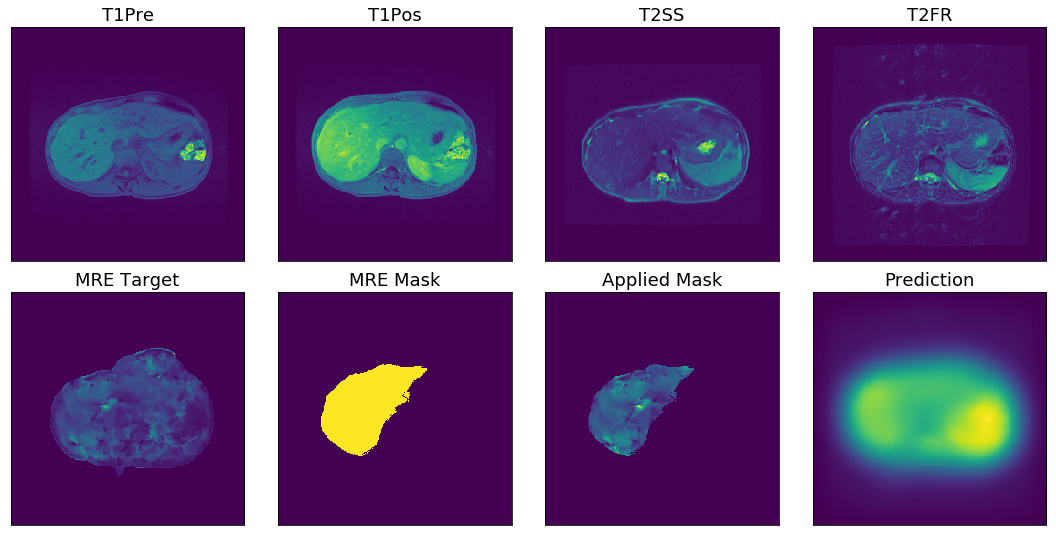

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(3.75*4, 3.75*2),
                             sharex=True, sharey=True,)
axs[0][0].imshow(inputs[0][0])
axs[0][0].set_title('T1Pre', size=18)

axs[0][1].imshow(inputs[0][1])
axs[0][1].set_title('T1Pos', size=18)
axs[0][2].imshow(inputs[0][2])
axs[0][2].set_title('T2SS', size=18)
axs[0][3].imshow(inputs[0][3])
axs[0][3].set_title('T2FR', size=18)
axs[1][0].imshow(labels[0][0])
axs[1][0].set_title('MRE Target', size=18)
axs[1][1].imshow(masks[0][0])
axs[1][1].set_title('MRE Mask', size=18)
axs[1][2].imshow(labels[0][0]*masks[0][0])
axs[1][2].set_title('Applied Mask', size=18)
axs[1][3].imshow(pred[0][0])
axs[1][3].set_title('Prediction', size=18)

plt.xticks([])
plt.yticks([])

fig.tight_layout()
plt.savefig('../plots/prediction.png')
plt.savefig('../plots/prediction.pdf')